In [ ]:
#Warnings 제거
import warnings
warnings.filterwarnings('ignore')

#문제상황

당뇨 환자는 지속적인 관찰과 치료가 필요하며, 중증 환자는 더욱 세심한 관리가 필요하다.
병원에서 중증 환자의 상태를 모니터링을하여  30일 이내에 재방문 해야하는 환자들을 예측하여 미리 조기 예약을 할 수 있도록 예방 조치를 취하는 방법이 필요하다.

#데이터 살펴보기

In [ ]:
from sklearn.datasets import fetch_openml
X_orig, y = fetch_openml(data_id = 43874, as_frame = True, return_X_y = True)

In [ ]:
X_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101766 non-null  object  
 1   gender                    101766 non-null  object  
 2   age                       101766 non-null  object  
 3   discharge_disposition_id  101766 non-null  object  
 4   admission_source_id       101766 non-null  object  
 5   time_in_hospital          101766 non-null  int64   
 6   medical_specialty         101766 non-null  object  
 7   num_lab_procedures        101766 non-null  int64   
 8   num_procedures            101766 non-null  int64   
 9   num_medications           101766 non-null  int64   
 10  primary_diagnosis         101766 non-null  object  
 11  number_diagnoses          101766 non-null  int64   
 12  max_glu_serum             101766 non-null  object  
 13  A1Cresult                 101

In [ ]:
X_orig.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary
0,Caucasian,Female,30 years or younger,Other,Referral,1,Other,41,0,1,...,No,No,No,False,False,False,False,False,NO,0
1,Caucasian,Female,30 years or younger,Discharged to Home,Emergency,3,Missing,59,0,18,...,Up,Ch,Yes,False,False,False,False,False,>30,1
2,AfricanAmerican,Female,30 years or younger,Discharged to Home,Emergency,2,Missing,11,5,13,...,No,No,Yes,False,False,False,True,True,NO,0
3,Caucasian,Male,30-60 years,Discharged to Home,Emergency,2,Missing,44,1,16,...,Up,Ch,Yes,False,False,False,False,False,NO,0
4,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,Missing,51,0,8,...,Steady,Ch,Yes,False,False,False,False,False,NO,0


#문제해결 프로세스 정의

##문제정의

퇴원한 환자들 중에 다시 입원하는 환자들이 늘어남

##기대효과

재입원 환자 예측을 통해 중증 환자 사전 조치 및 모니터링

중증 환자 생존율 증가

##해결방안

Binary classification을 통해 30일 이내 재입원할 환자를 분류

Session 1

- 인코딩을 통한 데이터 준비
- 베이스 모델 생성

Session 2
- Class weight가 오류에 미치는 영향 분석
- Hyperparameter 튜닝(

Session 3
- 에러를 서로 다른 주제 그룹으로 나눠보기
-Feature importance 알아보기

##성과측정

에러 분석을 통한 점진적 성능 향상

##현업적용

모델 성능 하락시 분석 포인트 탐색

#Session 1

##Data 전처리 및 EDA

In [ ]:
!pip install raiwidgets lightgbm optuna shap --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.9/157.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import math
import os
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import lightgbm as lgb
import optuna

from responsibleai import RAIInsights
from raiwidgets import ResponsibleAIDashboard
from raiutils.cohort import Cohort, CohortFilter, CohortFilterMethods
import shap

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

##Target 변수와 상관관계가 높은 feature 2개를 제거

In [ ]:
X_orig['readmitted'].value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

In [ ]:
X_orig['readmit_binary'].value_counts()

readmit_binary
0    54864
1    46902
Name: count, dtype: int64

In [ ]:
y.value_counts()

readmit_30_days
0    90409
1    11357
Name: count, dtype: int64

In [ ]:
#X_orig['readmitted']와 X_orig['readmit_binary']는 y와 직접적인 상관관계를 보이므로 학습 Feature에 사용할 수 없다.

In [ ]:
#

##인코딩을 통한 데이터 준비

In [ ]:
def transform_data(X_):
  X = X_.drop(['readmitted', 'readmit_binary'], axis = 1)

  bool_cols_l = X.select_dtypes(include = ['category']).columns.tolist()
  X[bool_cols_l] = X[bool_cols_l].astype(str).replace({'True' : 1, 'False' : 0})
  print(bool_cols_l)

  cat_cols_l = X.select_dtypes(include = ['object']).columns.tolist()
  print(cat_cols_l)
  ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
  ohe_np = ohe.fit_transform(X[cat_cols_l].astype('category'))
  X[ohe.get_feature_names_out(cat_cols_l)] = ohe_np.astype(int)

  X.drop(cat_cols_l, axis = 1, inplace = True)

  return X

In [ ]:
X = transform_data(X_orig)

['medicare', 'medicaid', 'had_emergency', 'had_inpatient_days', 'had_outpatient_days']
['race', 'gender', 'age', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'primary_diagnosis', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed']


In [ ]:
X.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Female,gender_Male,gender_Unknown/Invalid,age_30 years or younger,age_30-60 years,age_Over 60 years,discharge_disposition_id_Discharged to Home,discharge_disposition_id_Other,admission_source_id_Emergency,...,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Missing,medical_specialty_Other,primary_diagnosis_Diabetes,primary_diagnosis_Genitourinary Issues,primary_diagnosis_Musculoskeletal Issues,primary_diagnosis_Other,primary_diagnosis_Respiratory Issues,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,1,41,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
1,3,59,0,18,9,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1
2,2,11,5,13,6,0,0,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
3,2,44,1,16,7,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1
4,1,51,0,8,5,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1


In [ ]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: readmit_30_days, dtype: int64

In [ ]:
print(f'Number of Features: {len(X_orig.columns)}')
print(X_orig.columns)

Number of Features: 24
Index(['race', 'gender', 'age', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'primary_diagnosis', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'insulin', 'change', 'diabetesMed', 'medicare', 'medicaid',
       'had_emergency', 'had_inpatient_days', 'had_outpatient_days',
       'readmitted', 'readmit_binary'],
      dtype='object')


In [ ]:
print(f'Number of Features(After processing): {len(X.columns)}')
print(X.columns)

Number of Features(After processing): 54
Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_diagnoses', 'medicare', 'medicaid',
       'had_emergency', 'had_inpatient_days', 'had_outpatient_days',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_Unknown', 'gender_Female', 'gender_Male',
       'gender_Unknown/Invalid', 'age_30 years or younger', 'age_30-60 years',
       'age_Over 60 years', 'discharge_disposition_id_Discharged to Home',
       'discharge_disposition_id_Other', 'admission_source_id_Emergency',
       'admission_source_id_Other', 'admission_source_id_Referral',
       'medical_specialty_Cardiology', 'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_InternalMedicine', 'medical_specialty_Missing',
       'medical_specialty_Other', 'primary_diagnosis_Diabetes',
       'primary_diagnosis_Genitourinary Is

##데이터셋 분할

In [ ]:
rand = 42
os.environ['PYTHONHASHSEED'] = str(rand)
np.random.seed(rand)

In [ ]:
classes_l = ['No or > 30 days', ' < 30 days']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = rand)
X_orig_test = X_orig.loc[X_test.index]

##Evaluation 함수 정의

In [ ]:
def evaluate_class_mdl(fitted_model, X_train, X_test, y_train, y_test, plot = True, pct = True, thresh = 0.5):
  y_train_pred = fitted_model.predict(X_train).squeeze()
  if len(np.unique(y_train_pred)) > 2:
    y_train_pred =  np.where(y_train_pred > thresh, 1, 0)
    y_test_prob = fitted_model.predict(X_test).squeeze()
    y_test_pred = np.where(y_test_prob > thresh, 1, 0)
  else:
    y_test_prob = fitted_model.predict_proba(X_test)[:, 1]
    y_test_pred = np.where(y_test_prob > thresh, 1, 0)
  roc_auc_te = metrics.roc_auc_score(y_test, y_test_prob)

  cf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
  tn, fp, fn, tp = cf_matrix.ravel()
  acc_tr = metrics.accuracy_score(y_train, y_train_pred)
  acc_te = metrics.accuracy_score(y_test, y_test_pred)
  pre_te = metrics.precision_score(y_test, y_test_pred)
  rec_te = metrics.recall_score(y_test, y_test_pred)
  f1_te = metrics.f1_score(y_test, y_test_pred)
  mcc_te = metrics.matthews_corrcoef(y_test, y_test_pred)

  if plot:
    print(f'Accuracy_train: {acc_tr:.4f}\t\t Accuracy_test: {acc_te:.4f}')
    print(f'Precision_test: {pre_te:.4f}\t\t Recall_test: {rec_te:.4f}')
    print(f'ROC-AUC_test: {roc_auc_te:.4f}\t\t F1_test: {f1_te:.4f}\t\tMCC_test: {mcc_te:.4f}')

    if pct:
      ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot = True,
                       fmt = '.2%', cmap = 'Blues', annot_kws = {'size':16})
    else:
      ax = sns.heatmap(cf_matrix, annot = True,
                       fmt = '.2%', cmap = 'Blues', annot_kws = {'size':16})

    ax.set_xlabel('Predicted', fontsize = 12)
    ax.set_ylabel('Observed', fontsize = 12)
    plt.show()

    return y_train_pred, y_test_prob, y_test_pred

  else:
    t = cf_matrix.sum()
    metrics_dict = {'accuracy_train' : acc_tr, 'accuracy_test':acc_te, 'precision': pre_te, 'recall': rec_te,
                    'roc_auc': roc_auc_te, 'f1': f1_te, 'mcc':mcc_te, 'tn%': tn / t, 'fp%': fp / t, 'fn%': fn / t, 'tp%': tp / t}

    return metrics_dict

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.539713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
Accuracy_train: 0.8888		 Accuracy_test: 0.8877
Precision_test: 0.0000		 Recall_test: 0.0000
ROC-AUC_test: 0.6469		 F1_test: 0.0000		MCC_test: -0.0029


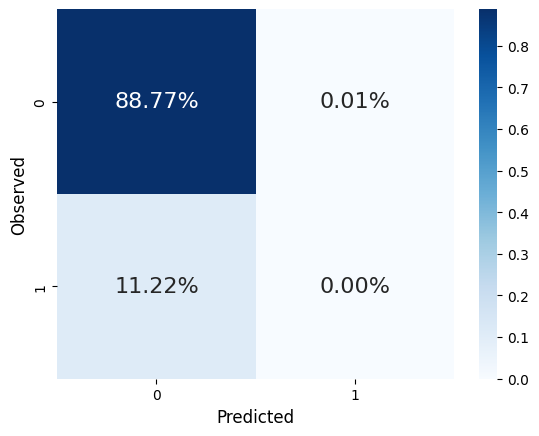

In [ ]:
%matplotlib inline
clf = lgb.LGBMClassifier(random_state = rand, n_jobs = -1)
clf.fit(X_train, y_train)

_ = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

Precision과 Recall이 매우 낮으므로 성능이 나쁘다고 판단

##Class Weights

모델은 기본적으로 Positive 클래스를 예측할 때 보수적 접근 방법으로 모델을 생성하기 떄문에 너무 많은 위험을 감수하지 않는다. 해결책은 Positive 클래스에 더 많은 비중을 두도록하는 것이다.

클래스 가중치를 부여하기 위하여 scale_pos_weight를 사용한다

In [ ]:
#num of negative / num of postive

def_scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
print(f'default scale pos weight: { def_scale_pos_weight:.2f}')

default scale pos weight: 7.96


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
Accuracy_train: 0.6381		 Accuracy_test: 0.6086
Precision_test: 0.1638		 Recall_test: 0.6064
ROC-AUC_test: 0.6458		 F1_test: 0.2580		MCC_test: 0.1379


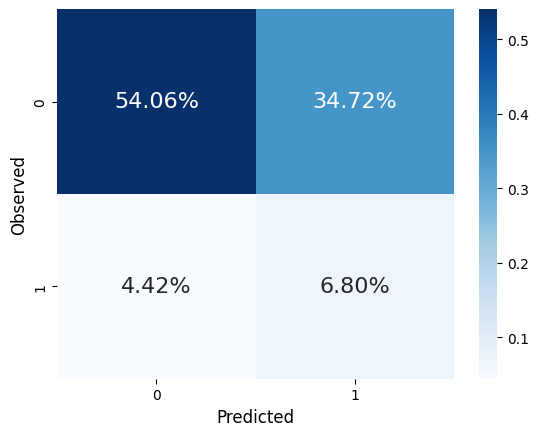

In [ ]:
clf = lgb.LGBMClassifier(random_state = rand, n_jobs = -1, scale_pos_weight = def_scale_pos_weight)
clf.fit(X_train, y_train)
_ = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.243037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
Accuracy_train: 0.3354		 Accuracy_test: 0.3157
Precision_test: 0.1293		 Recall_test: 0.8893
ROC-AUC_test: 0.6438		 F1_test: 0.2258		MCC_test: 0.0997


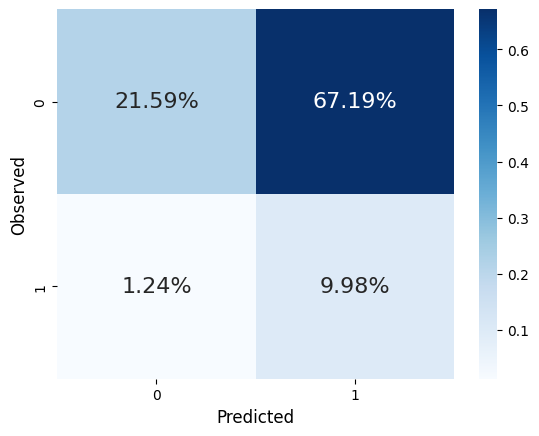

In [ ]:
#scale_weight를 두배를하면 오탐지가 두배가 된다
clf = lgb.LGBMClassifier(random_state = rand, n_jobs = -1, scale_pos_weight = def_scale_pos_weight * 2)
clf.fit(X_train, y_train)
_ = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
Accuracy_train: 0.8771		 Accuracy_test: 0.8617
Precision_test: 0.2232		 Recall_test: 0.0937
ROC-AUC_test: 0.6485		 F1_test: 0.1320		MCC_test: 0.0782


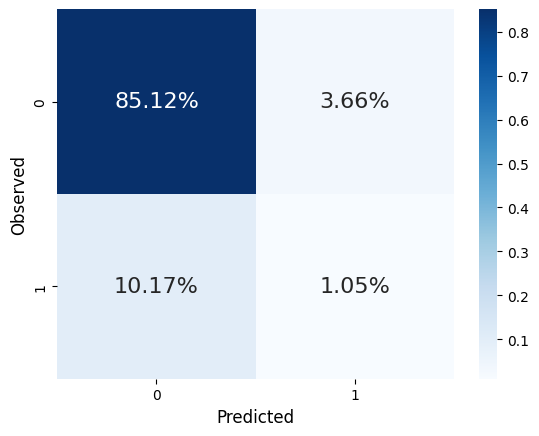

In [ ]:
clf = lgb.LGBMClassifier(random_state = rand, n_jobs = -1, scale_pos_weight = def_scale_pos_weight / 2)
clf.fit(X_train, y_train)
_ = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

Hyperparameter tuning

In [ ]:
min_tn = X_orig[X_orig['readmitted'] == 'NO'].shape[0] / X_orig.shape[0]
print(f'Patients % that never readmitted (Minimum % fo True Negatives): {min_tn:.2%}')

Patients % that never readmitted (Minimum % fo True Negatives): 53.91%


In [ ]:
max_fp = X_orig[X_orig['readmitted'] == '>30'].shape[0] / X_orig.shape[0]
print(f'Patients % that were readmitted over 30 days (Maximum % fo False Positive): {max_fp:.2%}')

Patients % that were readmitted over 30 days (Maximum % fo False Positive): 34.93%


In [ ]:
def optimize_lgb(trial):
  params = {
      'max_depth': trial.suggest_int('max_depth', 2, 11),
      'scale_pos_weight': trial.suggest_float('scale_pos_weight', def_scale_pos_weight / 2, def_scale_pos_weight * 2),
      'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log = True),
      'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log = True)
  }
  if params['max_depth'] == 11:
      params['max_depth'] = -1

  clf = lgb.LGBMClassifier(random_state = rand, n_jobs = -1, **params)
  clf.fit(X_train, y_train)

  metrics_dict = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test, plot = False)

  if (metrics_dict['tn%'] < min_tn) or (metrics_dict['fp%'] > max_fp):
    return 0

  return metrics_dict['recall']

In [ ]:
#optuna를 이용한 Hyperparameter tuning
%%time
opt_study = optuna.create_study(direction = 'maximize')
opt_study.optimize(optimize_lgb, n_trials = 100)

[I 2024-07-11 05:17:53,597] A new study created in memory with name: no-name-57641101-c28c-4b4f-9128-39ed06c9d606


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:17:56,544] Trial 0 finished with value: 0.13518248175182482 and parameters: {'max_depth': 4, 'scale_pos_weight': 4.3235067453488965, 'reg_lambda': 0.32088782047532355, 'reg_alpha': 0.01094714542148173}. Best is trial 0 with value: 0.13518248175182482.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.367458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num

[I 2024-07-11 05:18:03,704] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 9, 'scale_pos_weight': 11.603180207174074, 'reg_lambda': 1.952918288286884e-08, 'reg_alpha': 0.044289512975169726}. Best is trial 0 with value: 0.13518248175182482.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[I 2024-07-11 05:18:04,861] Trial 2 finished with value: 0.13138686131386862 and parameters: {'max_depth': 3, 'scale_pos_weight': 4.340551569168577, 'reg_lambda': 4.0410001402348676e-08, 'reg_alpha': 0.5758022026479436}. Best is trial 0 with value: 0.13518248175182482.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:18:06,335] Trial 3 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 7.97236713564575, 'reg_lambda': 4.569975040938477e-08, 'reg_alpha': 2.1715360679329185e-05}. Best is trial 0 with value: 0.13518248175182482.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num

[I 2024-07-11 05:18:07,848] Trial 4 finished with value: 0.43445255474452554 and parameters: {'max_depth': 10, 'scale_pos_weight': 6.172206549373556, 'reg_lambda': 3.7668719669442535e-05, 'reg_alpha': 8.87587242800667}. Best is trial 4 with value: 0.43445255474452554.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:18:09,052] Trial 5 finished with value: 0.0 and parameters: {'max_depth': 3, 'scale_pos_weight': 11.628645641974463, 'reg_lambda': 0.09813204677769174, 'reg_alpha': 0.03874427870132658}. Best is trial 4 with value: 0.43445255474452554.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:18:12,375] Trial 6 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 11.55411522725069, 'reg_lambda': 0.0019550669709888797, 'reg_alpha': 0.0007547120055478532}. Best is trial 4 with value: 0.43445255474452554.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-07-11 05:18:15,536] Trial 7 finished with value: 0.0 and parameters: {'max_depth': 2, 'scale_pos_weight': 14.114482870963155, 'reg_lambda': 0.001762089168609006, 'reg_alpha': 8.059587382618369e-08}. Best is trial 4 with value: 0.43445255474452554.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:18:17,023] Trial 8 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 9.576743049781552, 'reg_lambda': 0.27118655940468994, 'reg_alpha': 0.20730830691146368}. Best is trial 4 with value: 0.43445255474452554.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2024-07-11 05:18:18,382] Trial 9 finished with value: 0.30335766423357663 and parameters: {'max_depth': 11, 'scale_pos_weight': 5.379707426413702, 'reg_lambda': 8.545555772117935e-06, 'reg_alpha': 3.6762815534166273e-06}. Best is trial 4 with value: 0.43445255474452554.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2024-07-11 05:18:19,847] Trial 10 finished with value: 0.5074452554744525 and parameters: {'max_depth': 11, 'scale_pos_weight': 6.770459492629058, 'reg_lambda': 8.694814210463232e-06, 'reg_alpha': 5.450459497308435}. Best is trial 10 with value: 0.5074452554744525.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2024-07-11 05:18:21,321] Trial 11 finished with value: 0.4975182481751825 and parameters: {'max_depth': 11, 'scale_pos_weight': 6.743346676320462, 'reg_lambda': 1.1527576646466957e-05, 'reg_alpha': 6.335586047484418}. Best is trial 10 with value: 0.5074452554744525.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2024-07-11 05:18:22,733] Trial 12 finished with value: 0.5696350364963504 and parameters: {'max_depth': 11, 'scale_pos_weight': 7.4292201597622345, 'reg_lambda': 2.389875449802129e-06, 'reg_alpha': 4.4393712944928305}. Best is trial 12 with value: 0.5696350364963504.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:18:24,191] Trial 13 finished with value: 0.6005839416058394 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.839069459541065, 'reg_lambda': 1.0986734686302318e-06, 'reg_alpha': 0.0011253106795398491}. Best is trial 13 with value: 0.6005839416058394.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:18:26,251] Trial 14 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 8.904361995156963, 'reg_lambda': 6.164615664925289e-07, 'reg_alpha': 0.0007793057386802138}. Best is trial 13 with value: 0.6005839416058394.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[I 2024-07-11 05:18:30,083] Trial 15 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 8.028781190670399, 'reg_lambda': 6.668878181136452e-07, 'reg_alpha': 5.724484866752705e-08}. Best is trial 13 with value: 0.6005839416058394.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:18:31,571] Trial 16 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 10.480672157438118, 'reg_lambda': 7.31382458416253e-07, 'reg_alpha': 5.289316137715967e-05}. Best is trial 13 with value: 0.6005839416058394.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:18:33,033] Trial 17 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 13.56980221492645, 'reg_lambda': 0.00017782658637468705, 'reg_alpha': 0.005007284961127565}. Best is trial 13 with value: 0.6005839416058394.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:18:34,524] Trial 18 finished with value: 0.0 and parameters: {'max_depth': 9, 'scale_pos_weight': 15.774487590804526, 'reg_lambda': 8.803192650928395, 'reg_alpha': 7.606377941893825e-07}. Best is trial 13 with value: 0.6005839416058394.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:18:36,704] Trial 19 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.939993954481237, 'reg_lambda': 3.2663995091901195e-07, 'reg_alpha': 0.48292615010319967}. Best is trial 13 with value: 0.6005839416058394.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:18:38,238] Trial 20 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 10.258398670329376, 'reg_lambda': 0.004800080513687555, 'reg_alpha': 5.9974776360614494e-05}. Best is trial 13 with value: 0.6005839416058394.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num

[I 2024-07-11 05:18:40,249] Trial 21 finished with value: 0.5176642335766424 and parameters: {'max_depth': 10, 'scale_pos_weight': 6.966323849604626, 'reg_lambda': 5.166342560336775e-06, 'reg_alpha': 1.5935660935778533}. Best is trial 13 with value: 0.6005839416058394.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num

[I 2024-07-11 05:18:44,164] Trial 22 finished with value: 0.3308029197080292 and parameters: {'max_depth': 10, 'scale_pos_weight': 5.574771865155656, 'reg_lambda': 2.5687869338279165e-06, 'reg_alpha': 1.0883477603707905}. Best is trial 13 with value: 0.6005839416058394.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:18:45,542] Trial 23 finished with value: 0.5652554744525548 and parameters: {'max_depth': 10, 'scale_pos_weight': 7.333308516631645, 'reg_lambda': 0.00014535272187020913, 'reg_alpha': 0.004115305875366278}. Best is trial 13 with value: 0.6005839416058394.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:18:47,015] Trial 24 finished with value: 0.0 and parameters: {'max_depth': 9, 'scale_pos_weight': 8.832673095444783, 'reg_lambda': 0.00012630162950512811, 'reg_alpha': 0.002867203401840949}. Best is trial 13 with value: 0.6005839416058394.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:18:48,455] Trial 25 finished with value: 0.5745985401459854 and parameters: {'max_depth': 8, 'scale_pos_weight': 7.530646883603926, 'reg_lambda': 6.997948424805585e-05, 'reg_alpha': 0.000328697986844285}. Best is trial 13 with value: 0.6005839416058394.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits

[I 2024-07-11 05:18:50,060] Trial 26 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 8.965171116634762, 'reg_lambda': 1.7712496378984498e-07, 'reg_alpha': 0.00021958064212348818}. Best is trial 13 with value: 0.6005839416058394.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:18:51,516] Trial 27 finished with value: 0.35124087591240877 and parameters: {'max_depth': 7, 'scale_pos_weight': 5.692940390351421, 'reg_lambda': 4.2071273657946704e-05, 'reg_alpha': 4.524922042927956e-06}. Best is trial 13 with value: 0.6005839416058394.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:18:53,001] Trial 28 finished with value: 0.6043795620437956 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.84584812030025, 'reg_lambda': 0.0005598442442752496, 'reg_alpha': 0.0002427837227584375}. Best is trial 28 with value: 0.6043795620437956.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:18:56,504] Trial 29 finished with value: 0.14627737226277374 and parameters: {'max_depth': 6, 'scale_pos_weight': 4.342012392271441, 'reg_lambda': 0.016814459201991927, 'reg_alpha': 0.00023780593492773671}. Best is trial 28 with value: 0.6043795620437956.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:18:58,626] Trial 30 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 9.58531836195136, 'reg_lambda': 0.0010344772378994176, 'reg_alpha': 7.205329704510557e-06}. Best is trial 28 with value: 0.6043795620437956.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:18:59,960] Trial 31 finished with value: 0.6105109489051095 and parameters: {'max_depth': 4, 'scale_pos_weight': 7.633456351338942, 'reg_lambda': 4.0694896269834825e-05, 'reg_alpha': 0.01967297348450238}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:19:01,310] Trial 32 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 8.3363910308795, 'reg_lambda': 0.0006350124148559402, 'reg_alpha': 0.05055055397034794}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:19:02,821] Trial 33 finished with value: 0.46335766423357666 and parameters: {'max_depth': 5, 'scale_pos_weight': 6.471451762519386, 'reg_lambda': 3.223208773923361e-05, 'reg_alpha': 0.019406457669593178}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[I 2024-07-11 05:19:04,045] Trial 34 finished with value: 0.2283211678832117 and parameters: {'max_depth': 3, 'scale_pos_weight': 4.91787383686769, 'reg_lambda': 0.015283274144117537, 'reg_alpha': 0.0010874888951998922}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:19:05,568] Trial 35 finished with value: 0.5854014598540146 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.564130909385048, 'reg_lambda': 0.000325620468380371, 'reg_alpha': 0.00010884185126258577}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:19:07,064] Trial 36 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 8.573114230015618, 'reg_lambda': 0.00039064283156576147, 'reg_alpha': 6.715467063664897e-05}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:19:09,261] Trial 37 finished with value: 0.45605839416058397 and parameters: {'max_depth': 4, 'scale_pos_weight': 6.357002625623547, 'reg_lambda': 0.0055583692029554065, 'reg_alpha': 0.009350521984327842}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-07-11 05:19:12,026] Trial 38 finished with value: 0.0 and parameters: {'max_depth': 2, 'scale_pos_weight': 10.931127174558014, 'reg_lambda': 3.4166809402665884e-08, 'reg_alpha': 0.12406656796348145}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:19:13,406] Trial 39 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 9.470164832018918, 'reg_lambda': 2.4755211781055396e-05, 'reg_alpha': 0.0019052115358832225}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:19:14,891] Trial 40 finished with value: 0.5856934306569344 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.515192352638691, 'reg_lambda': 0.07454712193622683, 'reg_alpha': 2.0550259784819322e-05}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:19:16,406] Trial 41 finished with value: 0.5932846715328467 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.659643767166449, 'reg_lambda': 2.616031241299273, 'reg_alpha': 1.583307083662233e-05}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:19:17,884] Trial 42 finished with value: 0.41927007299270075 and parameters: {'max_depth': 5, 'scale_pos_weight': 6.069064425869949, 'reg_lambda': 4.288204263898042, 'reg_alpha': 2.039122271717498e-05}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[I 2024-07-11 05:19:19,126] Trial 43 finished with value: 0.0 and parameters: {'max_depth': 3, 'scale_pos_weight': 7.980023088181939, 'reg_lambda': 1.2281423615278717, 'reg_alpha': 6.624033851455386e-07}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:19:20,632] Trial 44 finished with value: 0.5497810218978102 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.1450124771512105, 'reg_lambda': 0.16347114966861864, 'reg_alpha': 1.808832587911665e-05}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[I 2024-07-11 05:19:22,027] Trial 45 finished with value: 0.0 and parameters: {'max_depth': 3, 'scale_pos_weight': 9.208453594131726, 'reg_lambda': 1.0569699059848778, 'reg_alpha': 8.319415978474993e-07}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:19:26,452] Trial 46 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 8.138411668769006, 'reg_lambda': 0.03447343885491598, 'reg_alpha': 0.00037205985530617836}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:19:27,919] Trial 47 finished with value: 0.27182481751824816 and parameters: {'max_depth': 6, 'scale_pos_weight': 5.084449287455385, 'reg_lambda': 0.9167612281814571, 'reg_alpha': 1.0055943348262147e-05}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:19:29,450] Trial 48 finished with value: 0.3953284671532847 and parameters: {'max_depth': 5, 'scale_pos_weight': 5.989371517164626, 'reg_lambda': 0.05447129159176352, 'reg_alpha': 2.195038073071045e-06}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[I 2024-07-11 05:19:30,819] Trial 49 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 12.546279350072709, 'reg_lambda': 1.3221201117765347e-08, 'reg_alpha': 0.0011642916387285566}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:19:32,168] Trial 50 finished with value: 0.5071532846715329 and parameters: {'max_depth': 4, 'scale_pos_weight': 6.700870111503785, 'reg_lambda': 0.42114981943855956, 'reg_alpha': 0.010010060181040153}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:19:34,205] Trial 51 finished with value: 0.5894890510948905 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.6636010636217895, 'reg_lambda': 0.003466840626694116, 'reg_alpha': 0.000107849966762356}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:19:35,680] Trial 52 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 8.39756752779646, 'reg_lambda': 0.004271026164851463, 'reg_alpha': 1.1886502183197102e-08}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:19:40,187] Trial 53 finished with value: 0.5935766423357665 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.604187248243047, 'reg_lambda': 0.0023800245014553687, 'reg_alpha': 3.4662676656510914e-05}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:19:41,713] Trial 54 finished with value: 0.5322627737226278 and parameters: {'max_depth': 6, 'scale_pos_weight': 6.993309999770143, 'reg_lambda': 0.002561952444124436, 'reg_alpha': 9.74061433928012e-05}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits

[I 2024-07-11 05:19:46,369] Trial 55 finished with value: 0.5935766423357665 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.586314980794459, 'reg_lambda': 0.0011085407206571937, 'reg_alpha': 3.6449747414541603e-05}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:19:47,894] Trial 56 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 8.569979398185954, 'reg_lambda': 0.0011522486434829545, 'reg_alpha': 1.679717662987017e-06}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:19:49,457] Trial 57 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 9.996738023857052, 'reg_lambda': 1.0356303462287917e-07, 'reg_alpha': 3.781007568699291e-05}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:19:52,580] Trial 58 finished with value: 0.0 and parameters: {'max_depth': 3, 'scale_pos_weight': 7.859805432297937, 'reg_lambda': 1.6374465925292897e-06, 'reg_alpha': 0.0005102286443752763}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.308020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:19:55,137] Trial 59 finished with value: 0.5299270072992701 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.014031421086183, 'reg_lambda': 1.5428905103910588e-05, 'reg_alpha': 9.521857910611708e-06}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:19:56,657] Trial 60 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 9.315865144559169, 'reg_lambda': 8.35722018357798e-05, 'reg_alpha': 0.00022398194045367373}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:19:58,148] Trial 61 finished with value: 0.5947445255474453 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.681193645244935, 'reg_lambda': 0.0005973393406971541, 'reg_alpha': 0.000156083790111922}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:19:59,720] Trial 62 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 8.904521499762012, 'reg_lambda': 0.0005613252578938528, 'reg_alpha': 3.72455461760411e-05}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:20:01,281] Trial 63 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 8.10842834494381, 'reg_lambda': 0.010351423197358437, 'reg_alpha': 0.00015488240838669115}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:20:02,806] Trial 64 finished with value: 0.5048175182481752 and parameters: {'max_depth': 6, 'scale_pos_weight': 6.776128610135167, 'reg_lambda': 0.0002364061594277702, 'reg_alpha': 0.0005901968680778045}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:20:04,464] Trial 65 finished with value: 0.5515328467153284 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.27237840950427, 'reg_lambda': 0.0007500840510533193, 'reg_alpha': 0.0023836225518833686}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.189835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:20:08,956] Trial 66 finished with value: 0.46832116788321165 and parameters: {'max_depth': 6, 'scale_pos_weight': 6.477031843070881, 'reg_lambda': 0.0001130351350717487, 'reg_alpha': 3.755861101801315e-05}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[I 2024-07-11 05:20:10,338] Trial 67 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 8.620217733427117, 'reg_lambda': 0.0015727591983828227, 'reg_alpha': 0.017567867848862505}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:20:11,858] Trial 68 finished with value: 0.6017518248175182 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.714108284736565, 'reg_lambda': 4.3816609546287165e-06, 'reg_alpha': 0.055954798335343676}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:20:13,385] Trial 69 finished with value: 0.3594160583941606 and parameters: {'max_depth': 8, 'scale_pos_weight': 5.773034685027472, 'reg_lambda': 5.709983021635121e-06, 'reg_alpha': 0.07261701768680819}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:20:14,887] Trial 70 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 10.623769078765939, 'reg_lambda': 2.5219121700989595e-06, 'reg_alpha': 0.21532665647991264}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:20:16,428] Trial 71 finished with value: 0.5935766423357665 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.639237200632536, 'reg_lambda': 3.65145943605565e-07, 'reg_alpha': 0.005773933947681479}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[I 2024-07-11 05:20:17,807] Trial 72 finished with value: 0.5792700729927007 and parameters: {'max_depth': 4, 'scale_pos_weight': 7.2934933691902515, 'reg_lambda': 1.290261761892981e-06, 'reg_alpha': 0.028359524639948716}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:20:20,987] Trial 73 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 8.21997282971319, 'reg_lambda': 4.929148094540603e-07, 'reg_alpha': 0.0067158512025285175}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.458274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:20:23,686] Trial 74 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 7.721234530239445, 'reg_lambda': 2.052890622786208e-07, 'reg_alpha': 0.0013024650326141417}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:20:25,240] Trial 75 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 9.70315500840799, 'reg_lambda': 5.136066156489831e-06, 'reg_alpha': 0.003023167256407796}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:20:26,749] Trial 76 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 9.099570007169422, 'reg_lambda': 6.768310950405857e-08, 'reg_alpha': 0.006015085111659372}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:20:28,296] Trial 77 finished with value: 0.4435036496350365 and parameters: {'max_depth': 5, 'scale_pos_weight': 6.304849636884651, 'reg_lambda': 4.7698217947233594e-05, 'reg_alpha': 0.26862217211030104}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:20:29,767] Trial 78 finished with value: 0.48875912408759126 and parameters: {'max_depth': 7, 'scale_pos_weight': 6.67202283740826, 'reg_lambda': 1.8935825062555827e-05, 'reg_alpha': 0.07447325635878833}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:20:31,291] Trial 79 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 8.58961366349152, 'reg_lambda': 1.0046317350329018e-06, 'reg_alpha': 0.01654830597520707}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:20:32,703] Trial 80 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 7.858722214443594, 'reg_lambda': 0.0004060653019803467, 'reg_alpha': 0.04307879568626694}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.298739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:20:37,353] Trial 81 finished with value: 0.5757664233576643 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.471787253987635, 'reg_lambda': 9.111296373473153e-06, 'reg_alpha': 1.3064852935072091e-05}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:20:38,912] Trial 82 finished with value: 0.545985401459854 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.144426426729523, 'reg_lambda': 3.109832846963102e-07, 'reg_alpha': 5.8659544389504947e-05}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start trai

[I 2024-07-11 05:20:40,443] Trial 83 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 8.267773315157063, 'reg_lambda': 0.00028067456216733294, 'reg_alpha': 6.1451873614374e-06}. Best is trial 31 with value: 0.6105109489051095.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[I 2024-07-11 05:20:41,823] Trial 84 finished with value: 0.6148905109489051 and parameters: {'max_depth': 4, 'scale_pos_weight': 7.686973946754627, 'reg_lambda': 0.0020751608135919364, 'reg_alpha': 0.0015423822467926986}. Best is trial 84 with value: 0.6148905109489051.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:20:43,031] Trial 85 finished with value: 0.0 and parameters: {'max_depth': 3, 'scale_pos_weight': 14.929995540581121, 'reg_lambda': 0.009309427644927397, 'reg_alpha': 0.0008367966752093494}. Best is trial 84 with value: 0.6148905109489051.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2024-07-11 05:20:44,575] Trial 86 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 7.894858765175332, 'reg_lambda': 0.0019185861264703005, 'reg_alpha': 0.0016571538661849245}. Best is trial 84 with value: 0.6148905109489051.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:20:45,961] Trial 87 finished with value: 0.5299270072992701 and parameters: {'max_depth': 4, 'scale_pos_weight': 6.893585565773796, 'reg_lambda': 0.0009688793041418378, 'reg_alpha': 0.0004333208177088454}. Best is trial 84 with value: 0.6148905109489051.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-07-11 05:20:48,906] Trial 88 finished with value: 0.5456934306569343 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.220428551827245, 'reg_lambda': 0.006331120413120415, 'reg_alpha': 0.0040173547813886195}. Best is trial 84 with value: 0.6148905109489051.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.471720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:20:51,736] Trial 89 finished with value: 0.6043795620437956 and parameters: {'max_depth': 3, 'scale_pos_weight': 7.497325988758606, 'reg_lambda': 0.0026032306311797233, 'reg_alpha': 0.12072174965602543}. Best is trial 84 with value: 0.6148905109489051.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-07-11 05:20:52,861] Trial 90 finished with value: 0.0 and parameters: {'max_depth': 2, 'scale_pos_weight': 8.800123852402752, 'reg_lambda': 0.02942866443470129, 'reg_alpha': 0.4423843227660204}. Best is trial 84 with value: 0.6148905109489051.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:20:54,119] Trial 91 finished with value: 0.6099270072992701 and parameters: {'max_depth': 3, 'scale_pos_weight': 7.560467281455062, 'reg_lambda': 0.002410118364266656, 'reg_alpha': 0.13382047788408036}. Best is trial 84 with value: 0.6148905109489051.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:20:55,365] Trial 92 finished with value: 0.0 and parameters: {'max_depth': 3, 'scale_pos_weight': 8.35714539093867, 'reg_lambda': 0.0026437381468345884, 'reg_alpha': 2.41349837054776}. Best is trial 84 with value: 0.6148905109489051.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:20:56,606] Trial 93 finished with value: 0.5991240875912409 and parameters: {'max_depth': 3, 'scale_pos_weight': 7.432832229652423, 'reg_lambda': 0.0014574679210313717, 'reg_alpha': 0.11934908701064677}. Best is trial 84 with value: 0.6148905109489051.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-07-11 05:20:57,722] Trial 94 finished with value: 0.4872992700729927 and parameters: {'max_depth': 2, 'scale_pos_weight': 6.593397535490127, 'reg_lambda': 0.0005545606674443446, 'reg_alpha': 0.6652249785594827}. Best is trial 84 with value: 0.6148905109489051.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:20:58,950] Trial 95 finished with value: 0.42686131386861315 and parameters: {'max_depth': 3, 'scale_pos_weight': 6.151390555364051, 'reg_lambda': 0.0014901105774117796, 'reg_alpha': 0.02840879405616676}. Best is trial 84 with value: 0.6148905109489051.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:21:00,183] Trial 96 finished with value: 0.0 and parameters: {'max_depth': 3, 'scale_pos_weight': 8.048677662006261, 'reg_lambda': 0.0031405476099738696, 'reg_alpha': 0.4041957221801282}. Best is trial 84 with value: 0.6148905109489051.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-07-11 05:21:01,588] Trial 97 finished with value: 0.5924087591240876 and parameters: {'max_depth': 2, 'scale_pos_weight': 7.363785797579802, 'reg_lambda': 0.00022235101511524892, 'reg_alpha': 0.11509797989259109}. Best is trial 84 with value: 0.6148905109489051.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:21:04,464] Trial 98 finished with value: 0.5372262773722628 and parameters: {'max_depth': 3, 'scale_pos_weight': 6.896172197287094, 'reg_lambda': 0.015031512969976266, 'reg_alpha': 0.12042931221323933}. Best is trial 84 with value: 0.6148905109489051.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-07-11 05:21:05,949] Trial 99 finished with value: 0.0 and parameters: {'max_depth': 3, 'scale_pos_weight': 8.44019133458661, 'reg_lambda': 0.006144322932861598, 'reg_alpha': 0.07592043938334983}. Best is trial 84 with value: 0.6148905109489051.


CPU times: user 4min 45s, sys: 4.11 s, total: 4min 49s
Wall time: 3min 12s


In [ ]:
best_params = opt_study.best_params
print(best_params)

{'max_depth': 4, 'scale_pos_weight': 7.686973946754627, 'reg_lambda': 0.0020751608135919364, 'reg_alpha': 0.0015423822467926986}


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

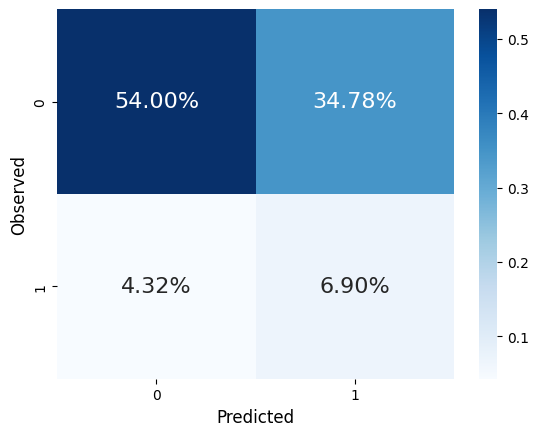

In [ ]:
clf = lgb.LGBMClassifier(random_state = rand, n_jobs = -1, **best_params)
clf.fit(X_train, y_train)
_, y_prob, y_pred = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

#Session 2 Error analysis

In [ ]:
X_orig_test['readmitted'].value_counts()

readmitted
NO     16461
>30    10644
<30     3425
Name: count, dtype: int64

In [ ]:
preds_df = pd.DataFrame({'readmitted':X_orig_test['readmitted'],\
                         'y_true':y_test.astype(int),\
                         'y_pred':y_pred})
preds_df[(preds_df.y_true==0) & (preds_df.y_pred==1)].value_counts(normalize=True)

readmitted  y_true  y_pred
NO          0       1         0.503485
>30         0       1         0.496515
Name: proportion, dtype: float64

In [ ]:
def set_header_font():
    return [dict(selector="th", props=[("font-size", "14pt")])]

def metrics_by_group(s):
    accuracy = metrics.accuracy_score(s.y_true, s.y_pred) * 100
    precision = metrics.precision_score(s.y_true, s.y_pred) * 100
    recall = metrics.recall_score(s.y_true, s.y_pred) * 100
    f1 = metrics.f1_score(s.y_true, s.y_pred) * 100
    roc_auc, fnr, fpr = np.nan, np.nan, np.nan
    if len(np.unique(s.y_true)) == 2:
        roc_auc = metrics.roc_auc_score(s.y_true, s.y_prob) * 100
        tn, fp, fn, tp = metrics.confusion_matrix(s.y_true, s.y_pred).ravel()
        fnr = (fn/(tp+fn)) * 100
        fpr = (fp/(tn+fp)) * 100
    support = len(s.y_true)

    return pd.Series((support, accuracy, precision, recall, f1, roc_auc, fnr, fpr),\
                 index=['support', 'accuracy', 'precision', 'recall', 'f1', 'roc-auc', 'fnr', 'fpr'])

def error_breakdown_by_group(mdl, y_true, y_prob, y_pred, orig_df, group_col, exclude_groups=None):

    print(f"Error breakdown for group '{group_col}'")

    predict_df = pd.DataFrame({group_col: orig_df[group_col].tolist(),\
                              'y_true': y_true,
                              'y_pred': y_pred,
                              'y_prob': y_prob}, index=y_true.index)
    if exclude_groups is not None:
        predict_df = predict_df[~predict_df[group_col].isin(exclude_groups)]

    group_metrics_df = predict_df.groupby([group_col]).apply(metrics_by_group)

    html = group_metrics_df.sort_values(by='support', ascending=False).style.\
            format({'support':'{:,.0f}', 'accuracy':'{:.1f}%', 'precision':'{:.1f}%', 'recall':'{:.1f}%',\
                    'f1':'{:.1f}%', 'roc-auc':'{:.1f}%', 'fnr':'{:.1f}%', 'fpr':'{:.1f}%'}).\
            set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font()).\
            highlight_max(subset=['accuracy','precision','recall','f1','roc-auc']).\
            highlight_min(subset=['fnr','fpr'])

    return html

def compare_confusion_matrices(y_true_1, y_pred_1, y_true_2, y_pred_2, group_1, group_2,\
                               plot=True, compare_fpr=False):

    conf_matrix_1 = metrics.confusion_matrix(y_true_1, y_pred_1)
    conf_matrix_2 = metrics.confusion_matrix(y_true_2, y_pred_2)

    if plot:
        fig, ax = plt.subplots(1,2,figsize=(12,5))
        sns.heatmap(conf_matrix_1/np.sum(conf_matrix_1), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[0])
        ax[0].set_title(group_1 + ' Confusion Matrix', fontsize=14)
        ax[0].set_xlabel('Predicted', fontsize=12)
        ax[0].set_ylabel('Observed', fontsize=12)
        sns.heatmap(conf_matrix_2/np.sum(conf_matrix_2), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[1])
        ax[1].set_title(group_2 + ' Confusion Matrix', fontsize=14)
        ax[1].set_xlabel('Predicted', fontsize=12)
        ax[1].set_ylabel('Observed', fontsize=12)
        plt.show()

In [ ]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='age')

Error breakdown for group 'age'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
age,,,,,,,,
Over 60 years,"20,566",57.4%,16.0%,61.3%,25.4%,62.5%,38.7%,43.2%
30-60 years,"9,201",67.6%,17.4%,61.1%,27.1%,68.5%,38.9%,31.6%
30 years or younger,763,75.1%,25.9%,70.7%,37.9%,77.3%,29.3%,24.4%


In [ ]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='gender',\
                         exclude_groups=['Unknown/Invalid'])

Error breakdown for group 'gender'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
gender,,,,,,,,
Female,"16,448",59.8%,16.4%,62.0%,26.0%,64.7%,38.0%,40.5%
Male,"14,080",62.2%,16.7%,60.9%,26.2%,65.4%,39.1%,37.6%


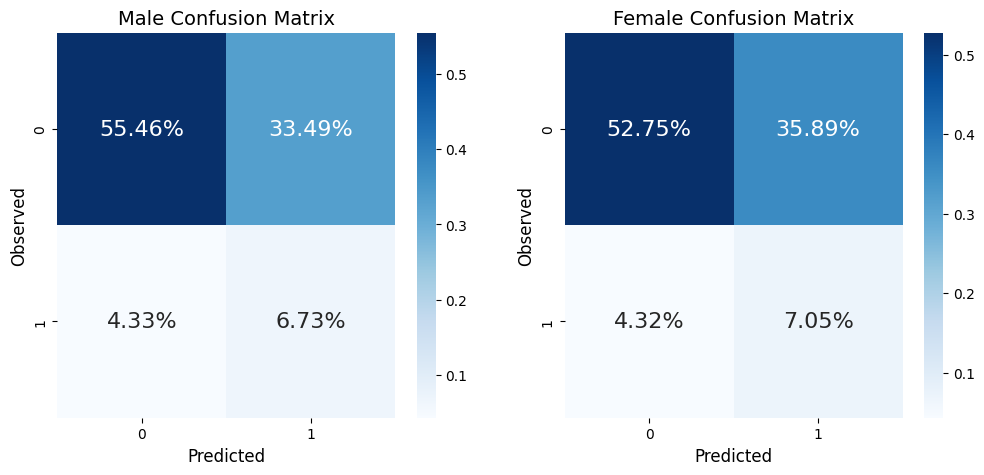

In [ ]:
_ = compare_confusion_matrices(y_test[X_test['gender_Male']==1], y_pred[X_test['gender_Male']==1],\
                           y_test[X_test['gender_Female']==1], y_pred[X_test['gender_Female']==1],\
                           'Male', 'Female')

In [ ]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='admission_source_id')

Error breakdown for group 'admission_source_id'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
admission_source_id,,,,,,,,
Emergency,"17,228",58.0%,16.9%,65.5%,26.9%,65.0%,34.5%,43.0%
Referral,"9,303",64.7%,16.4%,55.7%,25.4%,64.8%,44.3%,34.2%
Other,"3,999",64.6%,14.7%,55.6%,23.3%,64.6%,44.4%,34.4%


In [ ]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='had_inpatient_days')

Error breakdown for group 'had_inpatient_days'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
had_inpatient_days,,,,,,,,
False,"20,292",79.0%,14.4%,29.8%,19.4%,62.8%,70.2%,16.4%
True,"10,238",24.9%,17.4%,93.4%,29.3%,57.5%,6.6%,88.8%


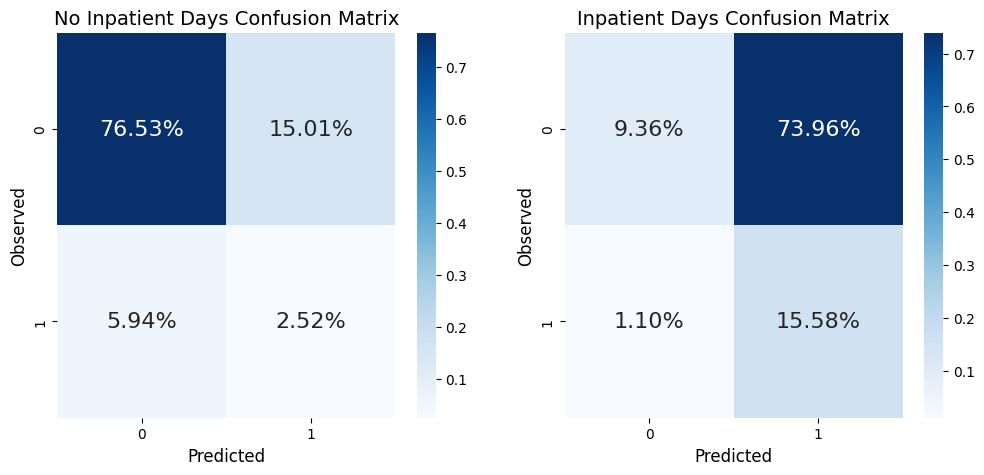

In [ ]:
_ = compare_confusion_matrices(y_test[X_test['had_inpatient_days']==0], y_pred[X_test['had_inpatient_days']==0],\
                           y_test[X_test['had_inpatient_days']==1], y_pred[X_test['had_inpatient_days']==1],\
                           'No Inpatient Days', 'Inpatient Days', compare_fpr=True)

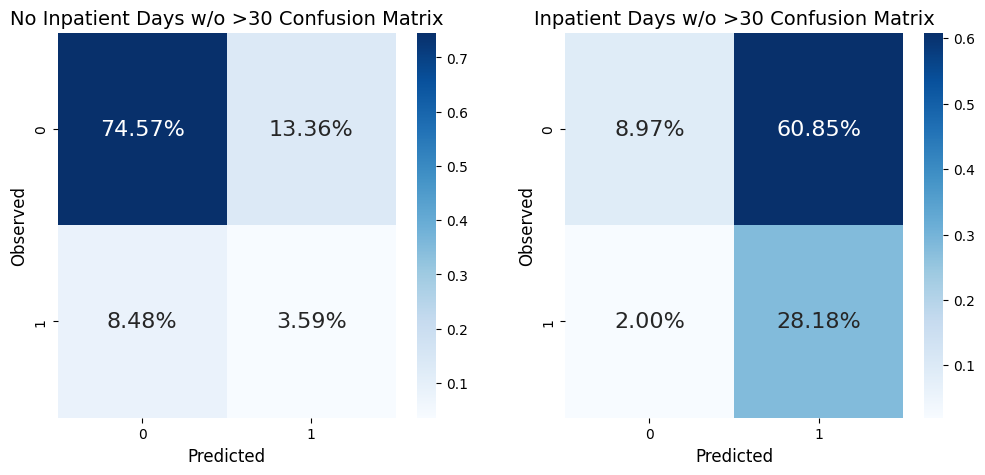

In [ ]:
_ = compare_confusion_matrices(y_test[(X_test['had_inpatient_days']==0) & (X_orig_test['readmitted']!='>30')], y_pred[(X_test['had_inpatient_days']==0) & (X_orig_test['readmitted']!='>30')],\
                           y_test[(X_test['had_inpatient_days']==1) & (X_orig_test['readmitted']!='>30')], y_pred[(X_test['had_inpatient_days']==1) & (X_orig_test['readmitted']!='>30')],\
                           'No Inpatient Days w/o >30', 'Inpatient Days w/o >30', compare_fpr=True)

#Session 3 주제그룹 분석

##Feature Importance and aMore Adbanced Error Analysis

In [ ]:
#sample
X_test_sample = X_test[(X_orig_test['readmitted'] != '>30')].sample(frac = 0.1)
y_test_sample = y_test.loc[X_test_sample.index]

y_prob_sample = clf.predict_proba(X_test_sample)[:, 1]
y_pred_sample = np.where(y_prob_sample > 0.5, 1, 0)

In [ ]:
X_test_sample

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Female,gender_Male,gender_Unknown/Invalid,age_30 years or younger,age_30-60 years,age_Over 60 years,discharge_disposition_id_Discharged to Home,discharge_disposition_id_Other,admission_source_id_Emergency,...,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Missing,medical_specialty_Other,primary_diagnosis_Diabetes,primary_diagnosis_Genitourinary Issues,primary_diagnosis_Musculoskeletal Issues,primary_diagnosis_Other,primary_diagnosis_Respiratory Issues,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
13175,10,55,1,14,6,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
65976,3,19,1,4,5,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
21084,4,57,2,10,5,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,...,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
93696,6,72,0,19,9,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
82563,6,56,0,19,9,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88361,3,49,3,15,8,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1
69981,3,60,6,23,9,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,...,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1
40161,9,41,1,23,5,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1
84129,3,56,0,8,4,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1


##SHAP value 생성

In [ ]:
%%time
shap_explanier = shap.Explainer(clf, X_train)
shap_values = shap_explanier(X_test_sample)

CPU times: user 5.93 s, sys: 69.9 ms, total: 6 s
Wall time: 9.38 s


In [ ]:
shap_values.values

array([[ 0.09069331,  0.03928752,  0.03221992, ...,  0.000275  ,
         0.06609381,  0.        ],
       [ 0.0080995 , -0.05061777,  0.02078638, ...,  0.000275  ,
        -0.08499253,  0.        ],
       [-0.00135409,  0.00981007, -0.03389188, ...,  0.000275  ,
        -0.13480393,  0.        ],
       ...,
       [ 0.05636972,  0.02660851,  0.0223207 , ...,  0.        ,
         0.02884503,  0.        ],
       [-0.03654467, -0.0090024 ,  0.04469232, ...,  0.        ,
         0.04002795,  0.        ],
       [ 0.17304634, -0.20852522, -0.01338948, ...,  0.        ,
         0.0303464 ,  0.        ]])

In [ ]:
print(shap_values.values.shape)

(1989, 54)


##Feature Importance Plots

In [ ]:
#한 축에서 shap값의 절대값을 평균화하면 기능 중요도 측정값(Feature당 하나)
np.abs(shap_values.values).mean(axis = 0)

array([6.36822787e-02, 5.84494915e-02, 2.85885698e-02, 5.76007814e-02,
       5.02596849e-02, 1.32788857e-02, 5.24078453e-04, 3.94237847e-02,
       2.79213925e-01, 5.46145648e-03, 6.77483736e-03, 8.61647918e-04,
       5.30065711e-03, 1.72938208e-03, 7.49737950e-03, 1.20960817e-02,
       3.24404532e-03, 6.86670028e-03, 0.00000000e+00, 2.80992488e-03,
       1.22199279e-03, 3.33154340e-02, 1.61415286e-01, 1.66360946e-04,
       5.72489674e-03, 1.63746022e-02, 1.84157556e-03, 1.26437212e-02,
       1.17906868e-02, 9.73002164e-03, 4.44551086e-03, 4.29347106e-03,
       2.96197234e-03, 1.31991448e-02, 9.94920388e-04, 1.34189228e-02,
       3.41206182e-02, 3.25533087e-02, 7.96430251e-04, 3.36096277e-04,
       5.70018814e-03, 7.52995321e-04, 2.53089772e-03, 2.24135127e-03,
       2.66669282e-02, 3.59241003e-03, 2.69664531e-02, 1.14672991e-02,
       2.74313900e-03, 7.54382750e-03, 7.07777103e-03, 1.74762607e-04,
       5.59137728e-02, 0.00000000e+00])

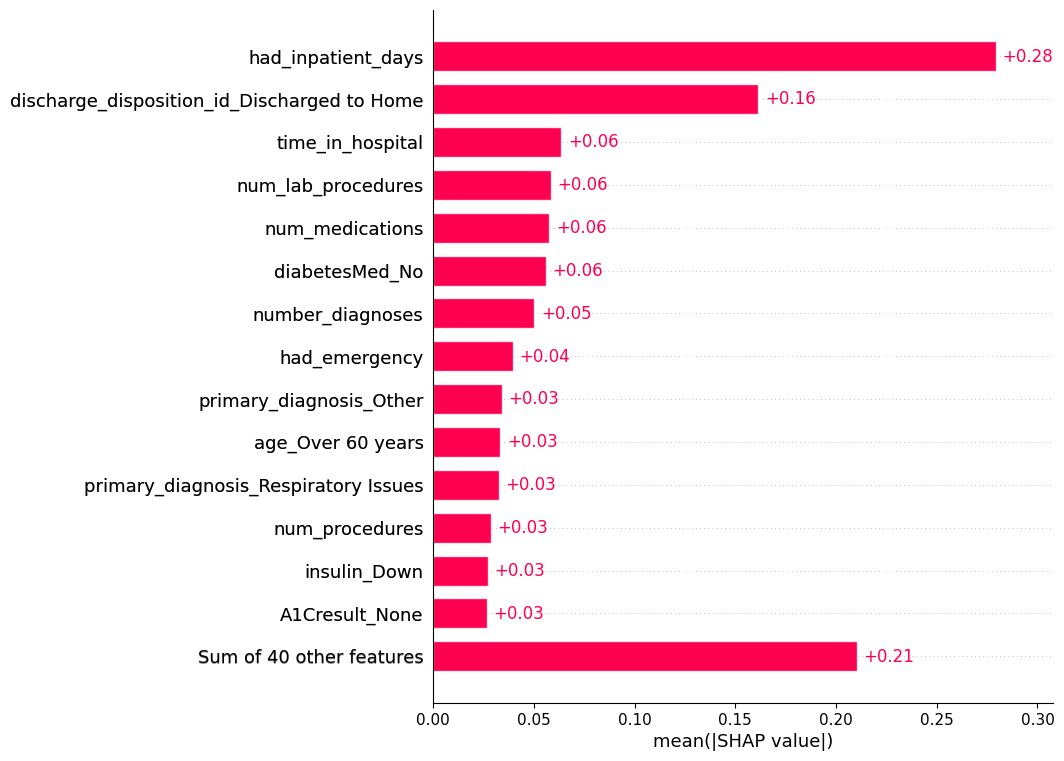

In [ ]:
shap.plots.bar(shap_values, max_display = 15)

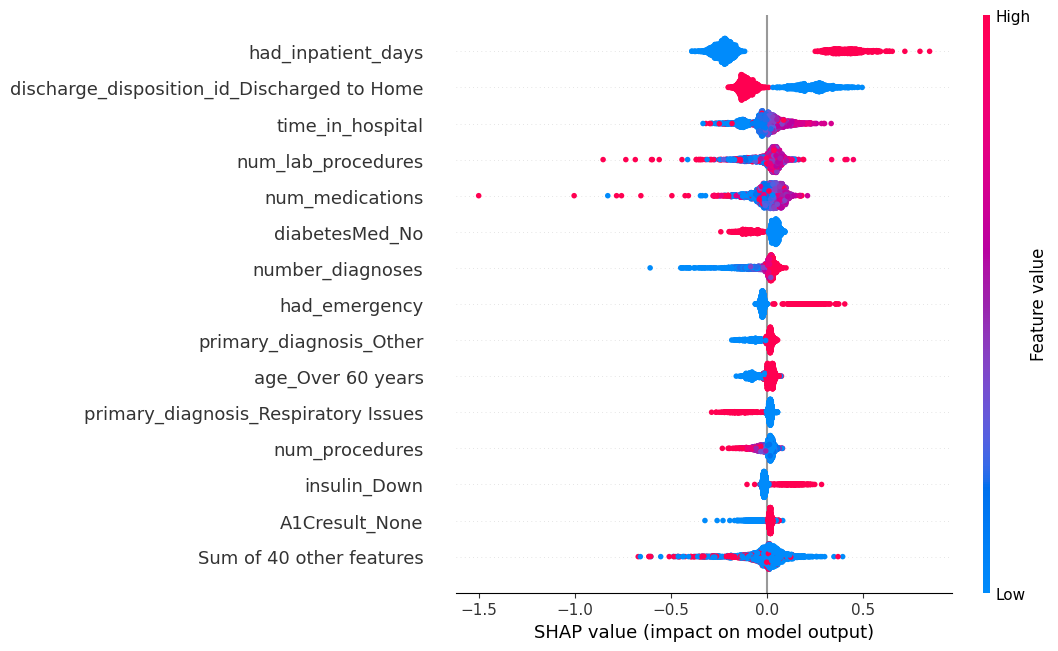

In [ ]:
shap.plots.beeswarm(shap_values, max_display = 15)

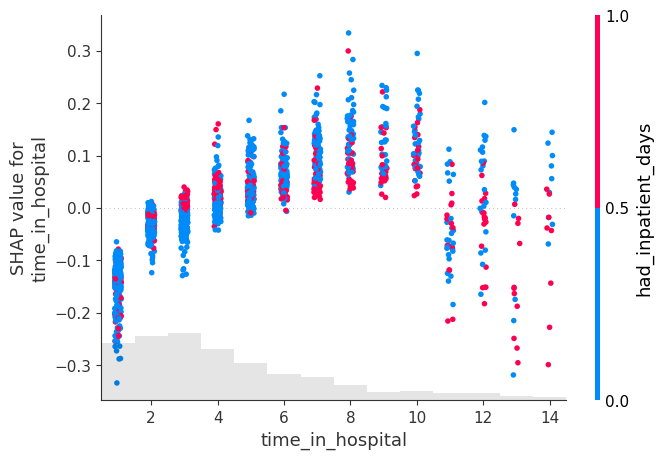

In [ ]:
shap.plots.scatter(shap_values[:, 'time_in_hospital'], color = shap_values[:, 'had_inpatient_days'])

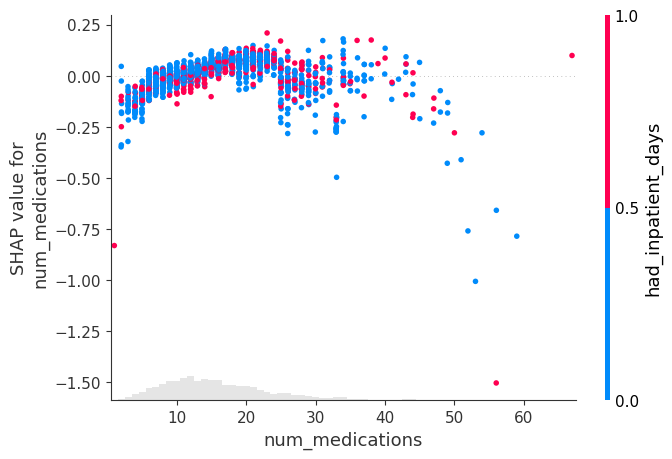

In [ ]:
shap.plots.scatter(shap_values[:, 'num_medications'], color = shap_values[:, 'had_inpatient_days'])

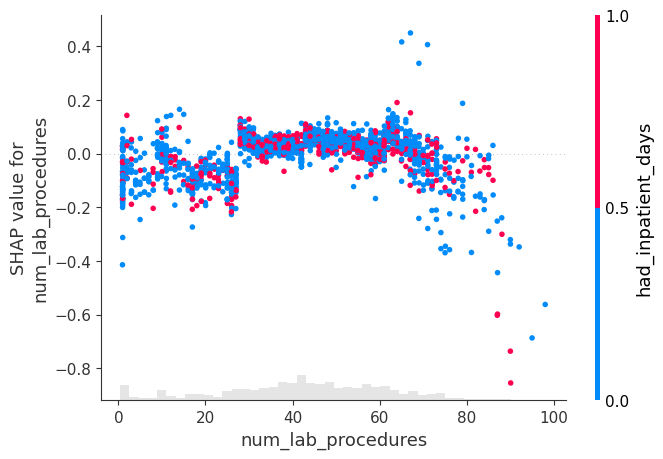

In [ ]:
shap.plots.scatter(shap_values[:, 'num_lab_procedures'], color = shap_values[:, 'had_inpatient_days'])

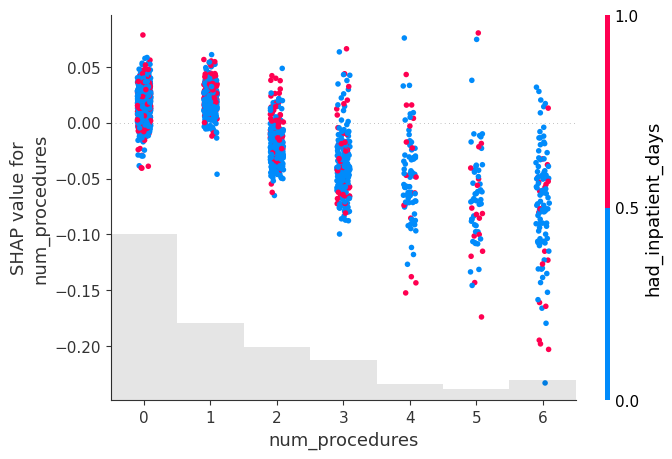

In [ ]:
shap.plots.scatter(shap_values[:, 'num_procedures'], color = shap_values[:, 'had_inpatient_days'])

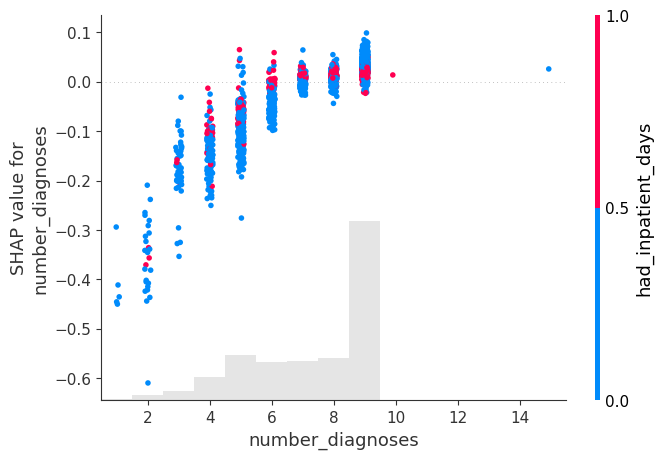

In [ ]:
shap.plots.scatter(shap_values[:, 'number_diagnoses'], color = shap_values[:, 'had_inpatient_days'])

In [ ]:
clf.predict(X_test)

array([0, 0, 1, ..., 0, 0, 1])